## Классификация текстов

В данном задании мы будем работать над задачей классификации последовательностей (текстов) с использованием различных методов векторизации слов.

In [1]:
# do not change the code in the block below
# __________start of block__________
import json
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython import display
from nltk.tokenize import WordPunctTokenizer
from sklearn import naive_bayes
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

%matplotlib inline


out_dict = dict()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# __________end of block__________

### Предобработка текста и токенизация

Предобработка практически аналогична рассмотренной на предшествующем занятии. Библиотека `nltk` [link](https://www.nltk.org) широко используется при обработке текстов. По ссылке выше можно найти ее развернутое описание и документацию.

In [2]:
# do not change the code in the block below
# __________start of block__________
df = pd.read_csv(
    "https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv",
    delimiter="\t",
    header=None,
)
texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]


tokenizer = WordPunctTokenizer()
preprocess = lambda text: " ".join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print(
    "before:",
    text,
)
print(
    "after:",
    preprocess(text),
)

texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]

# Small check that everything is done properly
assert (
    texts_train[5]
    == "campanella gets the tone just right funny in the middle of sad in the middle of hopeful"
)
assert texts_test[74] == "poetry in motion captured on film"
assert len(texts_test) == len(y_test)
# __________end of block__________

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown - up at work : replace " i don ' t want to do that " with " ok , great !".


Следующие функции помогут вам с визуализацией процесса обучения сети.

In [3]:
# do not change the code in the block below
# __________start of block__________


def plot_train_process(
    train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=""
):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(" ".join(["Loss", title_suffix]))
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()

    axes[1].set_title(" ".join(["Validation accuracy", title_suffix]))
    axes[1].plot(train_accuracy, label="train")
    axes[1].plot(val_accuracy, label="validation")
    axes[1].legend()
    plt.show()


def visualize_and_save_results(
    model, model_name, X_train, X_test, y_train, y_test, out_dict
):
    for data_name, X, y, model in [
        ("train", X_train, y_train, model),
        ("test", X_test, y_test, model),
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError("Unrecognized model type")

        auc = roc_auc_score(y, proba)

        out_dict[f"{model_name}_{data_name}"] = auc
        plt.plot(*roc_curve(y, proba)[:2], label="{} AUC={:.4f}".format(data_name, auc))

    plt.plot(
        [0, 1],
        [0, 1],
        "--",
        color="black",
    )
    plt.legend(fontsize="large")
    plt.title(model_name)
    plt.grid()
    return out_dict


# __________end of block__________

## Повторение: основные понятия в глубоком обучении

__Слой (layer)__ – некоторое преобразование над исходными данными. Простейший пример: линейный слой, являющийся линейным преобразованием над входящими данными (т.е. просто преобразование $WX +b$, как и в линейной регрессии).

__Функция активации (activation function)__ – нелинейное преобразование, применяется ко всем данным пришедшим на вход поэлементно. Благодаря функциям активации нейронные сети делают *нелинейные преобразования* над исходными признаками, тем самым порождая более информативное признаковое описание.

__Нейронная сеть (neural network)__ – композиция линейных и нелинейных преобразований (как правило, представимая в виде последовательности слоев и функций активации). Изучением нейронных сетей и их применимости в различных задачах занимается глубокое обучение (Deep Learning). В большинстве случаев вся нейронная сеть является одной сложной *дифференцируемой* функцией, что накладывает ограничения на возможность использование тех или иных преобразований.

__Регуляризация (regularization)__ – механизм наложения ограничений на решение в зависимости от экспертных знаний и/или априорных предположений о решаемой задаче. Может быть представлена в форме дополнительного члена в функции потерь (например, $L1$ или $L2$ регуляризация), в форме ограничений на структуру модели (`Dropout`, `Batch Normalization`) и в других формах.

__Функция потерь (loss function)__ – функция потерь, оценивающая качество полученного предсказания. Как правило, от функции потерь требуется свойство дифференцируемости (т.к. настройка параметров сети происходит методом *обратного распространения ошибки*). В некоторых случаях (например, в обучении с подкреплением) используются и недифференцируемые функции потерь/награды. Их использование требует доработки механизма обучения нейронных сетей.

## Работа с текстами и последовательностями

* __Последовательности__. Данные – наборы значений, на которых задано отношение порядка. Значения могут быть дискретными (например, ДНК), или же могут принимать значения из непрерывного интервала (временной ряд энергопотребления дата центра). Перестановка значений приводит к потере информации. Нельзя нарушать отношение порядка (тестирование на прошлом, обучение на будущем).

* __Тексты__. Данные – наборы слов/символов. По факту являются последовательностями значений из конечного алфавита, но обладают достаточно строгой внутренней структурой ввиду существования грамматики.

В работе с естественным языком (в виде текста в первую очередь), а также в работе с последовательностями себя отлично зарекомендовали рекуррентные сети и сети, основанные на механизме внимания (attention mechanism), подобные модели Transformer, предложенной в 2017 году в работе Attention is all you need. Как рекуррентные, так и transformer-like модели учитывают зависимость элементов последовательности друг от друга (и в целом наличие порядка), что позволяет им порождать информативные признаковые представления автоматически (подобно сверточным сетям при работе с изображениями).

### Задача №1. Мешок слов.

Воспользуйтесь классическим подходом к векторизации текстов: мешком слов. Для этого вы можете как воспользоваться `CountVectorizer` из `sklearn`, так и самостоятельно реализованный вариант.

Мешок слов сопоставляет каждому слову из словаря уникальный индекс (номер слова в словаре) и строит итоговый вектор для текста как набор счетчиков каждого слова из словаря. Этот подход эквивалентен построению суммы `one-hot` векторов для каждого из слов в тексте.

#### __One-hot кодирование__.
Каждому слову в языке можно сопоставить уникальный индекс и поставить слову в соответствие вектор, где нули стоят на всех местах, кроме заданного индекса. Такой подход называется one-hot кодированием. Пример такого кодирования можно увидеть ниже.

*Пример: слово "собака" находится на третьем месте в словаре из 5 слов. Тогда ему будет соответствовать вектор `[0, 0, 1, 0, 0]`. Слово "кошка" стоит на втором месте, ему соответствует вектор `[0, 1, 0, 0, 0]`. Слово "кот" – на четвёртом, ему соответствует вектор `[0, 0, 0, 1, 0]`.*



Обращаем ваше внимание, в части 1 используется лишь `k` наиболее часто встречаемых слов из обучающей части выборки.

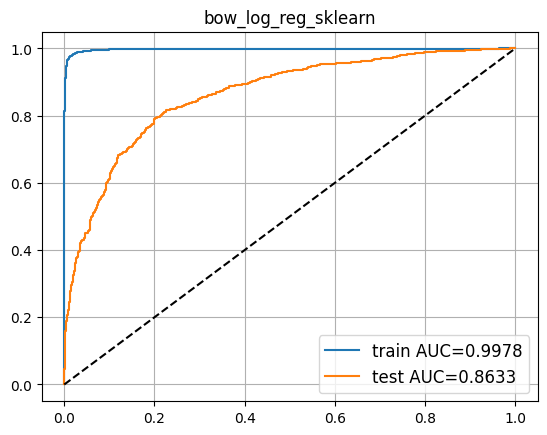

In [4]:
# do not change the code in the block below
# __________start of block__________

k = min(10000, len(set(" ".join(texts_train).split())))

counts = Counter(" ".join(texts_train).split())

bow_vocabulary = [key for key, val in counts.most_common(k)]


def text_to_bow(text):
    """convert text string to an array of token counts. Use bow_vocabulary."""
    sent_vec = np.zeros(len(bow_vocabulary))
    counts = Counter(text.split())
    for i, token in enumerate(bow_vocabulary):
        if token in counts:
            sent_vec[i] = counts[token]
    return np.array(sent_vec, "float32")


X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

# Small check that everything is done properly if you are using local bow implementation
k_max = len(set(" ".join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(
    X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in texts_train[5:10]])
)
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[65, bow_vocabulary.index("!")] == texts_train[65].split().count("!")


bow_model = LogisticRegression(max_iter=1500).fit(X_train_bow, y_train)

out_dict = visualize_and_save_results(
    bow_model, "bow_log_reg_sklearn", X_train_bow, X_test_bow, y_train, y_test, out_dict
)
# __________end of block__________

Результаты неплохие, но явно видно переобучение. Этот вывод можно сделать судя по значительному превосходству качества (AUC ROC) на train выборке относительно test. Более того, на обучающей выборке качество стремится к единице, в то время как на отложенной – значительно ниже, т.е. модель уловила множество зависимостей, свойственных лишь обучающей выборке. Базово проблема переобучения рассматривалась в предыдущих занятиях и еще не раз встретится на курсе в дальнейшем.

В данной задаче с переобучением мы разберемся в дальнейшем. Сейчас же реализуйте решение на основе логистической регрессии, но уже используя PyTorch. В результате вам должна быть доступна обученная модель, предсказывающая вероятности для двух классов. Качество на тестовой выборке должно не уступать логистической регрессии.

In [81]:
# your code here
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 2)

    def forward(self, x):
        return self.linear(x)

model = LogisticRegressionModel(input_size=len(bow_vocabulary))

Не забывайте о функциях потерь: `nn.CrossEntropyLoss` объединяет в себе `LogSoftMax` и `NLLLoss`. Также не забывайте о необходимости перенести тензоры на используемый `device`.

In [21]:
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

X_train_bow_torch = torch.tensor(X_train_bow, dtype=torch.float32).to(device)
X_test_bow_torch = torch.tensor(X_test_bow, dtype=torch.float32).to(device)

y_train_torch = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_torch = torch.tensor(y_test, dtype=torch.long).to(device)

Функция ниже поможет с обучением модели. Часть кода необходимо реализовать самостоятельно.

In [23]:
def train_model(
    model,
    opt,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    show_plots=True,
    eval_every=50
):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample batch_size random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch) # your code here

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch) # your code here

        # compute gradients
        loss.backward() # your code here

        # Adam step
        opt.step() # your code here

        # clear gradients
        opt.zero_grad() # your code here

        local_train_loss_history.append(loss.item())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

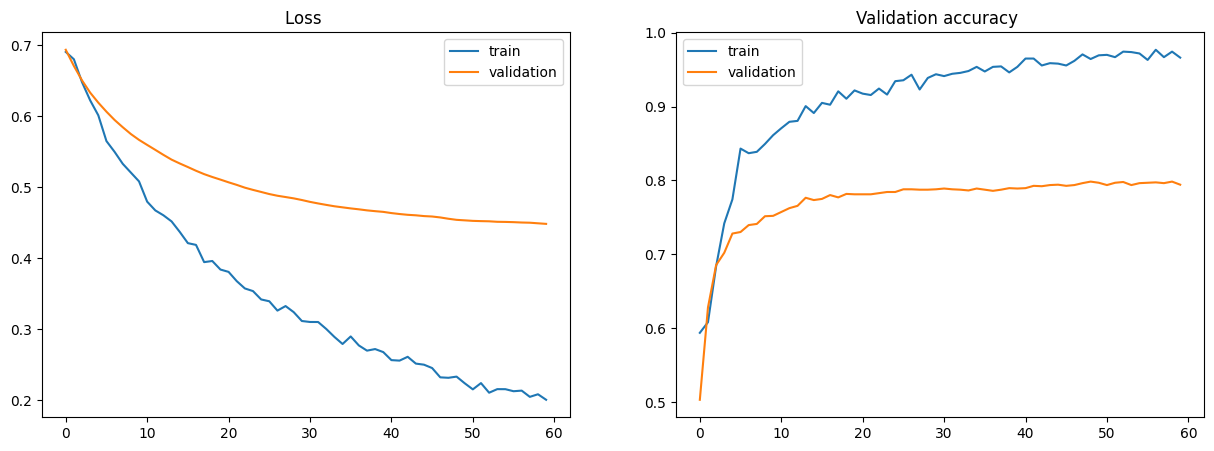

In [24]:
bow_nn_model = train_model(
    model,
    opt,
    X_train_bow_torch,
    y_train_torch,
    X_test_bow_torch,
    y_test_torch,
    n_iterations=3000,
)

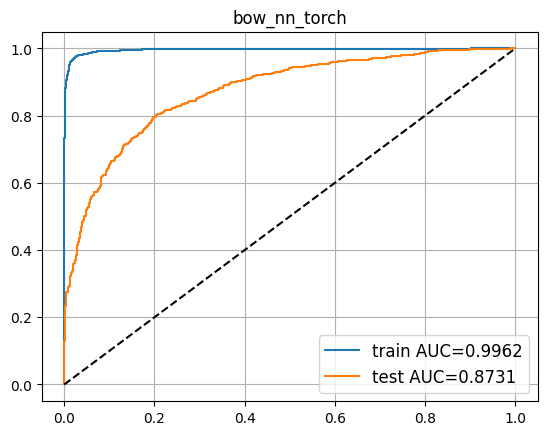

In [25]:
# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(
    bow_nn_model,
    "bow_nn_torch",
    X_train_bow_torch,
    X_test_bow_torch,
    y_train,
    y_test,
    out_dict,
)

assert (
    out_dict["bow_log_reg_sklearn_test"] - out_dict["bow_nn_torch_test"] < 0.01
), "AUC ROC on test data should be close to the sklearn implementation"
# __________end of block__________

А теперь повторите процедуру обучения выше, но для различных значений `k` – размера словаря. В список results сохраните `AUC ROC` на тестовой части выборки для модели, обученной со словарем размера `k`.

In [27]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []

def text_to_bow(text):
    sent_vec = np.zeros(len(bow_vocabulary))
    counts = Counter(text.split())
    for i, token in enumerate(bow_vocabulary):
        if token in counts:
            sent_vec[i] = counts[token]
    return np.array(sent_vec, "float32")

for k in vocab_sizes_list:
    # your code here
    counts = Counter(" ".join(texts_train).split())
    bow_vocabulary = [key for key, val in counts.most_common(k)]

    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

    X_train_bow_torch = torch.tensor(X_train_bow, dtype=torch.float32).to(device)
    X_test_bow_torch = torch.tensor(X_test_bow, dtype=torch.float32).to(device)

    y_train_torch = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test_torch = torch.tensor(y_test, dtype=torch.long).to(device)

    model = LogisticRegressionModel(input_size=k).to(device)
    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    bow_nn_model = train_model(
        model,
        opt,
        X_train_bow_torch,
        y_train_torch,
        X_test_bow_torch,
        y_test_torch,
        n_iterations=3000,
        show_plots=False
    )

    with torch.no_grad():
        predicted_probas = torch.softmax(bow_nn_model(X_test_bow_torch), dim=1)[:, 1]
        predicted_probas_on_test_for_k_sized_dict = predicted_probas.cpu().numpy()

  #  predicted_probas_on_test_for_k_sized_dict = None
    assert predicted_probas_on_test_for_k_sized_dict is not None
    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)
    print(f'k = {k}, ROC-AUC: {auc}')

k = 100, ROC-AUC: 0.6837481013883105
k = 800, ROC-AUC: 0.8172891358639458
k = 1500, ROC-AUC: 0.8447867955566235
k = 2200, ROC-AUC: 0.8546568582148864
k = 2900, ROC-AUC: 0.862263808356827
k = 3600, ROC-AUC: 0.8650966402863385
k = 4300, ROC-AUC: 0.8651319759369656
k = 5000, ROC-AUC: 0.8687981855958841
k = 5700, ROC-AUC: 0.8719870921586386


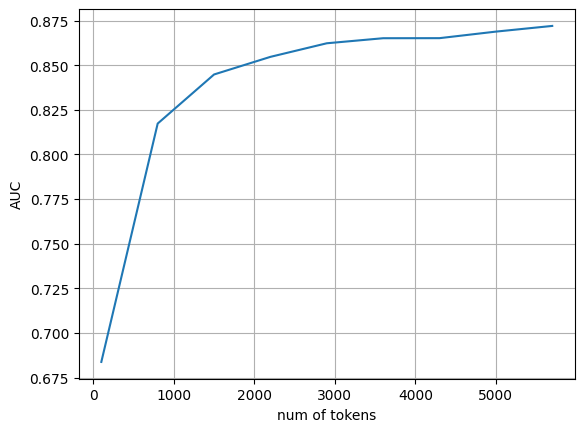

In [28]:
# do not change the code in the block below
# __________start of block__________
assert len(results) == len(vocab_sizes_list), "Check the code above"
assert min(results) >= 0.65, "Seems like the model is not trained well enough"
assert results[-1] > 0.84, "Best AUC ROC should not be lower than 0.84"

plt.plot(vocab_sizes_list, results)
plt.xlabel("num of tokens")
plt.ylabel("AUC")
plt.grid()

out_dict["bow_k_vary"] = results
# __________end of block__________

### Задача №2: Использование TF-iDF признаков.

Для векторизации текстов также можно воспользоваться TF-iDF. Это позволяет исключить из рассмотрения многие слова, не оказывающие значимого влияния при оценке непохожести текстов.

Подробнее про TF-iDF можно почитать, например, [здесь](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089).
Там же можно почитать о его самостоятельной реализации.

Ваша задача: векторизовать тексты используя TF-iDF (или `TfidfVectorizer` из `sklearn`, или реализовав его самостоятельно) и построить классификатор с помощью PyTorch, аналогичный задаче №1.

Затем также оцените качество классификации по AUC ROC для различных размеров словаря.

Качество классификации должно быть не ниже 0.86 AUC ROC.

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [89]:
tfidf_vectorizer = TfidfVectorizer(max_features=5600)
X_train_tfidf = tfidf_vectorizer.fit_transform(texts_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(texts_test).toarray()

X_train_tfidf_torch = torch.tensor(X_train_tfidf, dtype=torch.float32).to(device)
X_test_tfidf_torch = torch.tensor(X_test_tfidf, dtype=torch.float32).to(device)

y_train_torch = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_torch = torch.tensor(y_test, dtype=torch.long).to(device)


In [91]:
model = LogisticRegressionModel(input_size=5600).to(device)
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

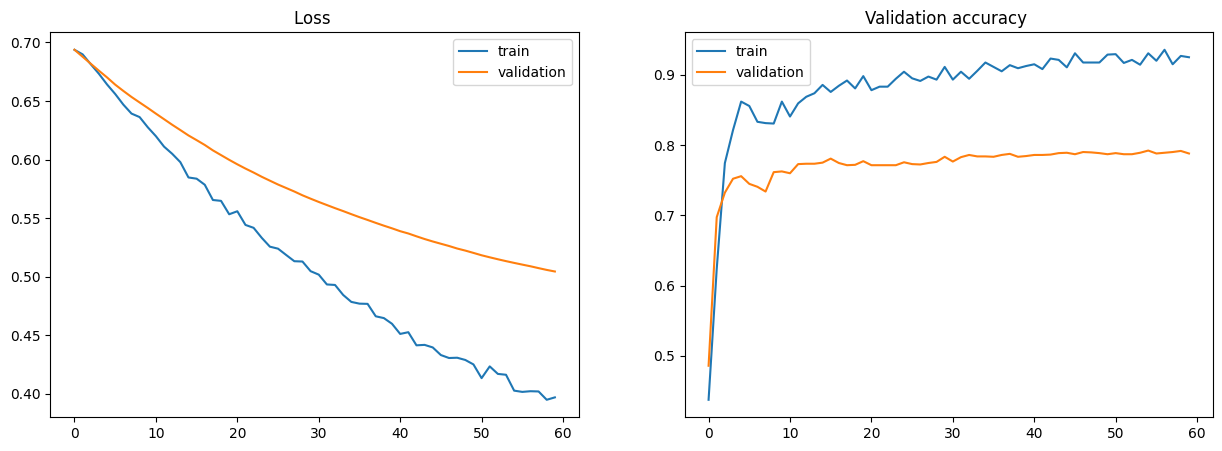

In [92]:
model_tf_idf = train_model(model, opt, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=3000)

0.8743529498744769


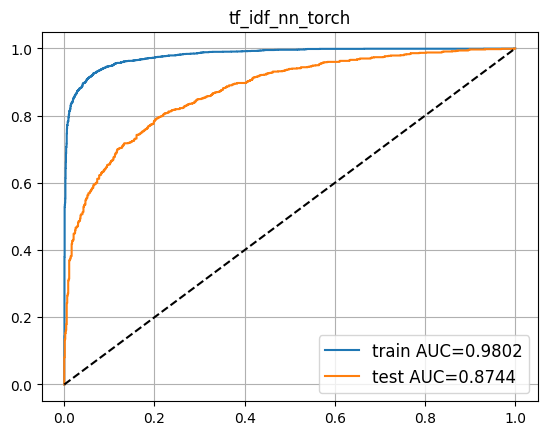

In [93]:
# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(
    model_tf_idf,
    "tf_idf_nn_torch",
    X_train_tfidf_torch,
    X_test_tfidf_torch,
    y_train,
    y_test,
    out_dict,
)
print(out_dict["tf_idf_nn_torch_test"])
assert (
    out_dict["tf_idf_nn_torch_test"] >= out_dict["bow_nn_torch_test"]
), "AUC ROC on test data should be better or close to BoW for TF-iDF features"
# __________end of block__________

Аналогично задаче №1 повторите процедуру обучения для различных значений `k` – размера словаря и сохраните `AUC ROC` на тестовой части выборки в список `results`.

In [94]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []

for k in vocab_sizes_list:
    # your code here
    tfidf_vectorizer = TfidfVectorizer(max_features=k)
    X_train_tfidf = tfidf_vectorizer.fit_transform(texts_train).toarray()
    X_test_tfidf = tfidf_vectorizer.transform(texts_test).toarray()

    X_train_tfidf_torch = torch.tensor(X_train_tfidf, dtype=torch.float32).to(device)
    X_test_tfidf_torch = torch.tensor(X_test_tfidf, dtype=torch.float32).to(device)

    y_train_torch = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test_torch = torch.tensor(y_test, dtype=torch.long).to(device)

    model = LogisticRegressionModel(input_size=k).to(device)
    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    model_tf_idf = train_model(
        model,
        opt,
        X_train_tfidf_torch,
        y_train_torch,
        X_test_tfidf_torch,
        y_test_torch,
        n_iterations=3000,
        show_plots=False,
    )

    with torch.no_grad():
        predicted_probas = torch.softmax(model_tf_idf(X_test_tfidf_torch), dim=1)[:, 1]
        predicted_probas_on_test_for_k_sized_dict = predicted_probas.cpu().numpy()

    #predicted_probas_on_test_for_k_sized_dict = None
    assert predicted_probas_on_test_for_k_sized_dict is not None
    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)
    print(f'k = {k}, ROC-AUC: {auc}')

k = 100, ROC-AUC: 0.6944140316237764
k = 800, ROC-AUC: 0.8163388786747717
k = 1500, ROC-AUC: 0.8480469170460267
k = 2200, ROC-AUC: 0.860211078868085
k = 2900, ROC-AUC: 0.8653450770915171
k = 3600, ROC-AUC: 0.8674086790881446
k = 4300, ROC-AUC: 0.8672847324982522
k = 5000, ROC-AUC: 0.8723665426838351
k = 5700, ROC-AUC: 0.8755880667702454


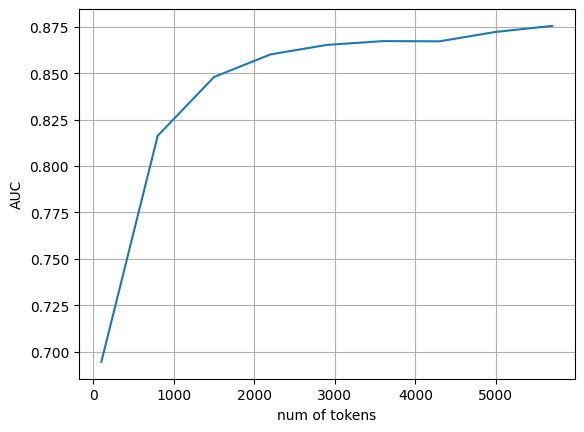

In [95]:
# do not change the code in the block below
# __________start of block__________
assert len(results) == len(vocab_sizes_list), "Check the code above"
assert min(results) >= 0.65, "Seems like the model is not trained well enough"
assert results[-1] > 0.85, "Best AUC ROC for TF-iDF should not be lower than 0.84"

plt.plot(vocab_sizes_list, results)
plt.xlabel("num of tokens")
plt.ylabel("AUC")
plt.grid()

out_dict["tf_idf_k_vary"] = results
# __________end of block__________

### Задача №3: Сравнение с Наивным Байесовским классификатором.

Классические модели все еще способны показать хороший результат во многих задачах. Обучите наивный байесовский классификатор на текстах, векторизованных с помощью BoW и TF-iDF и сравните результаты с моделями выше.

*Комментарий: обращаем ваше внимание, необходимо выбрать подходящее к данной задаче априорное распределение для признаков, т.е. выбрать верную версию классификатора из `sklearn`: `GaussianNB`, **`MultinomialNB`**, **`ComplementNB`**, `BernoulliNB`, `CategoricalNB`*

In [96]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


ROC-AUC (BoW): 0.8735


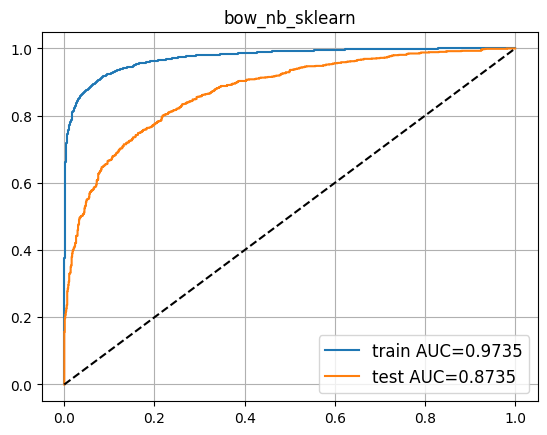

In [99]:
clf_nb_bow = MultinomialNB() # your code here
clf_nb_bow.fit(X_train_bow, y_train)

y_proba_bow = clf_nb_bow.predict_proba(X_test_bow)[:, 1]
auc_bow_nb = roc_auc_score(y_test, y_proba_bow)
print(f"ROC-AUC (BoW): {auc_bow_nb:.4f}")

# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(clf_nb_bow, 'bow_nb_sklearn', X_train_bow, X_test_bow, y_train, y_test, out_dict)
# __________end of block__________

ROC-AUC (TF-IDF): 0.8831


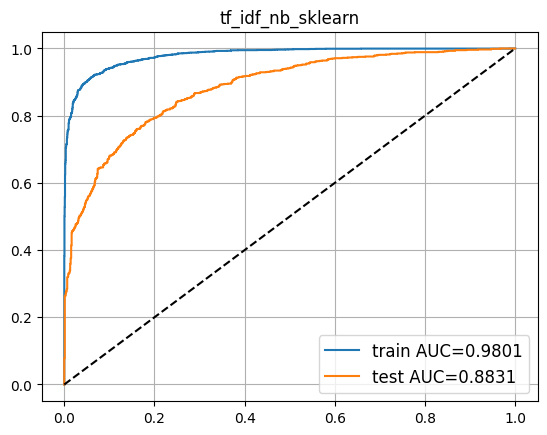

In [100]:
clf_nb_tfidf = MultinomialNB()  # your code here
clf_nb_tfidf.fit(X_train_tfidf, y_train)

y_proba_tfidf = clf_nb_tfidf.predict_proba(X_test_tfidf)[:, 1]
auc_tfidf_nb = roc_auc_score(y_test, y_proba_tfidf)
print(f"ROC-AUC (TF-IDF): {auc_tfidf_nb:.4f}")

# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(clf_nb_tfidf, 'tf_idf_nb_sklearn', X_train_tfidf, X_test_tfidf, y_train, y_test, out_dict)
# __________end of block__________

In [101]:
# do not change the code in the block below
# __________start of block__________
assert (
    out_dict["tf_idf_nb_sklearn_test"] > out_dict["bow_nb_sklearn_test"]
), " TF-iDF results should be better"
assert (
    out_dict["tf_idf_nb_sklearn_test"] > 0.86
), "TF-iDF Naive Bayes score should be above 0.86"
# __________end of block__________

### Задача №4: Использование предобученных эмбеддингов
#### __Построение эмбеддингов с помощью word2vec__.
Предложенные выше подходы обладают существенными недостатками: они не учитывает смысл слов при сопоставлении вектора каждому из них. Поэтому расстояние между one-hot векторами для слов "кошка" и "собака", для слов "кошка" и "самолет" или для слов "кошка" и "кот" будет одинаковой. Для владеющего языком человека разница между словами очевидна, как и то, что "кошка" и "кот" гораздо ближе друг к другу по смыслу, чем "кошка" и "самолет". При построении информативного векторного представления также хотелось бы установить смысловую близость слов.

С этим может помочь простая мысль (озвученная в различных формах множество раз): __слово в значительной мере определяется контекстом, в котором оно встречается__. На основании чего можно сделать простой вывод: для некоторых слов более характерен один контекст, а для других – другой. Именно на этой идее и построен word2vec (как и многие другие эмбеддинги).

По слову можно научиться предсказывать контекст, в котором оно встречается. Конечно, результат не будет идеально точным. Но если модель делает предсказания лучше, чем случайным образом, значит, она улавливает какую-то связь. И тогда внутреннее представление модели для каждого слова и может использоваться в качестве искомого векторного представления, причем и в других задачах.


Формулировка гипотезы выше (слово значительно связано с контекстом) позволяет использовать в качестве обучающей выборки все множество текстов для выбранного языка. Собрание сочинений классиков, статьи в энциклопедии, новостные заметки – все это становится обучающей выборкой. И векторные представления, полученные на основе данных текстов позволяют улавливать связь между этими словами.
![](https://ruder.io/content/images/size/w2000/2016/04/word_embeddings_colah.png)
*Image source: https://ruder.io/word-embeddings-1/*

В данной части для получения предобученных векторных представлений  мы воспользуемся предобученными эмбеддингами из библиотеки `gensim`. В нем доступно несколько эмбеддингов, предобученных на различных корпусах текстов. Полный список можно найти [здесь](https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models). Напоминаем, что лучше использовать те эмбеддинги, которые были обучены на текстах похожей структуры.

Ваша задача: обучить модель (достаточно логистической регрессии или же двуслойной неронной сети), используя усредненный эмбеддинг для всех токенов в отзыве, добиться качества не хуже, чем с помощью BoW/TF-iDF и снизить степень переобучения (разницу между AUC ROC на обучающей и тестовой выборках).

In [130]:
import gensim.downloader as api

gensim_embedding_model = api.load('glove-wiki-gigaword-300')
print(f"Embedding size: {gensim_embedding_model.vector_size}")

[==================================================] 100.0% 376.1/376.1MB downloaded
Embedding size: 300


In [131]:
def text_to_average_embedding(text, gensim_embedding_model):
    # your code here
    tokens = text.split()
    embeddings = [
        gensim_embedding_model[word] for word in tokens if word in gensim_embedding_model
    ]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(gensim_embedding_model.vector_size)


In [132]:
X_train_emb = [
    text_to_average_embedding(text, gensim_embedding_model) for text in texts_train
]
X_test_emb = [
    text_to_average_embedding(text, gensim_embedding_model) for text in texts_test
]

assert (
    len(X_train_emb[0]) == gensim_embedding_model.vector_size
), "Seems like the embedding shape is wrong"

In [134]:
X_train_emb_torch = torch.tensor(X_train_emb, dtype=torch.float32)
X_test_emb_torch = torch.tensor(X_test_emb, dtype=torch.float32)

y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

In [140]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 2)

    def forward(self, x):
        return self.linear(x)

In [141]:
model = LogisticRegressionModel(input_size=gensim_embedding_model.vector_size)

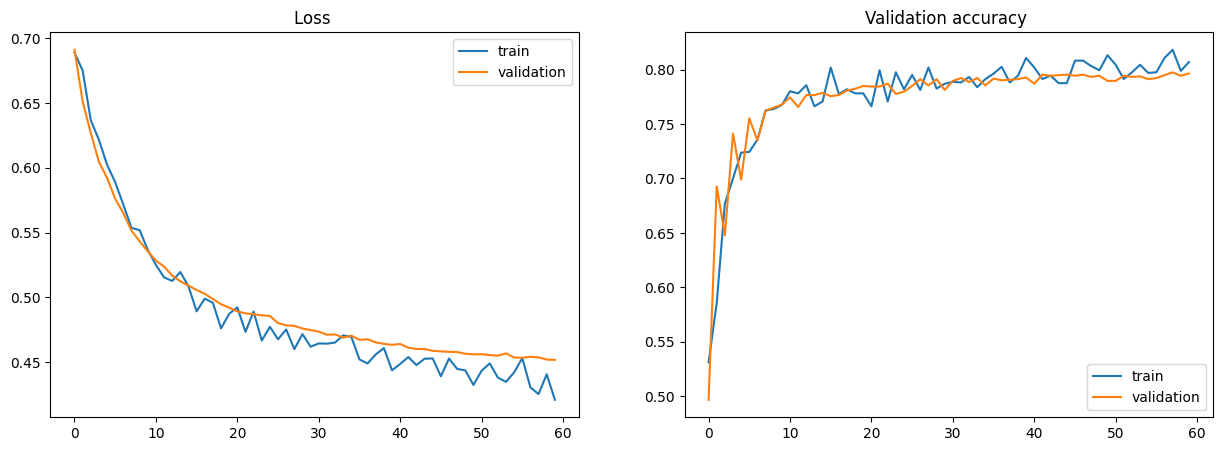

In [142]:
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

model = train_model(model, opt, X_train_emb_torch, y_train_torch, X_test_emb_torch, y_test_torch, n_iterations=3000)

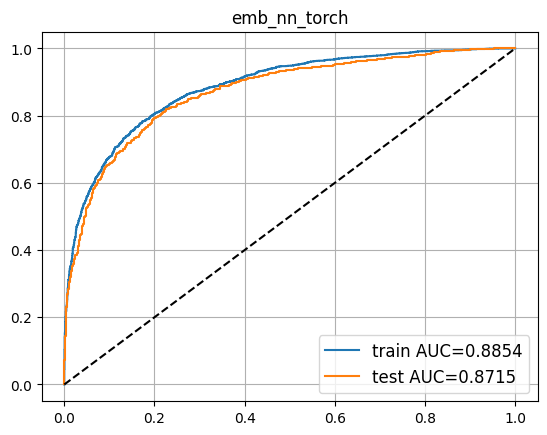

In [143]:
# do not change the code in the block below
# __________start of block__________

out_dict = visualize_and_save_results(
    model,
    "emb_nn_torch",
    X_train_emb_torch,
    X_test_emb_torch,
    y_train,
    y_test,
    out_dict,
)
assert (
    out_dict["emb_nn_torch_test"] > 0.87
), "AUC ROC on test data should be better than 0.86"
assert (
    out_dict["emb_nn_torch_train"] - out_dict["emb_nn_torch_test"] < 0.1
), "AUC ROC on test and train data should not be different more than by 0.1"
# __________end of block__________

### Сдача задания
Запустите код ниже для генерации посылки и сдайте на проверку в контест файл `submission_dict_hw_text_classification.json`.

In [144]:
# do not change the code in the block below
# __________start of block__________
FILENAME = "submission_dict_hw_text_classification.json"
with open(FILENAME, "w") as iofile:
    json.dump(out_dict, iofile)
print(f"File saved to `{FILENAME}`")
# __________end of block__________

File saved to `submission_dict_hw_text_classification.json`
